In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [11]:
# Load dataset
df = pd.read_csv("prep.csv")
df = pd.get_dummies(df, drop_first=True)

In [12]:
df.head(3)

,age,bp,al,su,bgr,bu,sc,sod,pot,hrmo,...,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_yes,pe_yes,ane_yes,classification_yes
0,2.0,76.459948,3.0,0.0,148.112676,57.482105,3.077356,137.528754,4.627244,12.518156,...,False,False,False,False,False,False,True,True,False,True
1,3.0,76.459948,2.0,0.0,148.112676,22.000000,0.700000,137.528754,4.627244,10.700000,...,True,False,False,False,False,False,True,False,False,True
2,4.0,76.459948,1.0,0.0,99.000000,23.000000,0.600000,138.000000,4.400000,12.000000,...,True,False,False,False,False,False,True,False,False,True


In [13]:
X = df.drop("classification_yes", axis=1)
y = df["classification_yes"]

# Use Logistic Regression as base estimator for feature selection
X_selected = forward_select_features(X, y, LogisticRegression(max_iter=1000), k_features=5)

# Split and scale
def split_scalar(indep_X, dep_Y):
    X_train, X_test, y_train, y_test = train_test_split(indep_X, dep_Y, test_size=0.25, random_state=0)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_scalar(X_selected, y)

In [5]:
from sklearn.feature_selection import SequentialFeatureSelector

def forward_select_features(X, y, estimator, k_features):
    sfs = SequentialFeatureSelector(estimator, n_features_to_select=k_features, direction='forward')
    sfs.fit(X, y)
    selected_features = X.columns[sfs.get_support()]
    return X[selected_features]

In [6]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return classifier, acc, report, cm

In [8]:
# Store accuracy for each model
accuracies = {}

models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "SVM_Linear": SVC(kernel='linear'),
    "SVM_RBF": SVC(kernel='rbf'),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier()
}

for name, model in models.items():
    clf, acc, report, cm = evaluate_model(model, X_train, y_train, X_test, y_test)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    # print(report)  # Optional

# Convert to DataFrame
result_df = pd.DataFrame([accuracies], index=["ForwardSelection"])
print("\nModel Accuracy Comparison:\n")
print(result_df)


Logistic Accuracy: 0.9800
SVM_Linear Accuracy: 0.9800
SVM_RBF Accuracy: 0.9900
KNN Accuracy: 0.9800
NaiveBayes Accuracy: 0.8700
DecisionTree Accuracy: 0.9800
RandomForest Accuracy: 0.9800

Model Accuracy Comparison:

                  Logistic  SVM_Linear  SVM_RBF   KNN  NaiveBayes  \
ForwardSelection      0.98        0.98     0.99  0.98        0.87   

                  DecisionTree  RandomForest  
ForwardSelection          0.98          0.98  


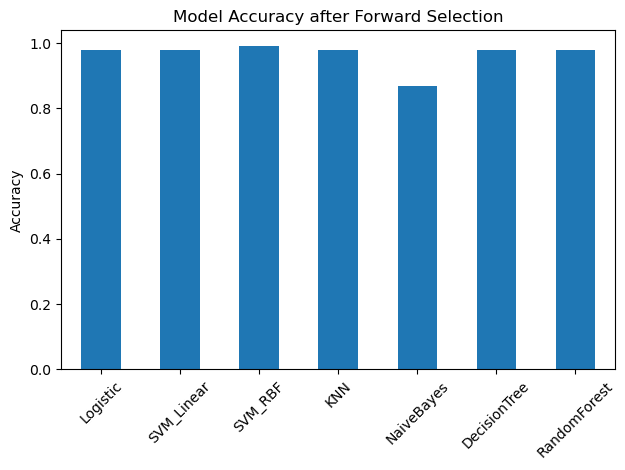

In [16]:
result_df.T.plot(kind='bar', legend=False)
plt.title("Model Accuracy after Forward Selection")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()